In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/data-jobs/all_jobs.csv
/kaggle/input/data-skills/skills_taxonomy.csv


# Data Job Skills - Building a (Network) Graph

## This notebook will seek primarily to analyze the job description field of this dataset.  

I want to thank [Kenza's article](https://medium.com/swlh/want-to-become-a-data-analyst-scientist-or-engineer-66902875bf9b) for providing the keywords that made this possible.  

In [2]:
jobs = pd.read_csv('/kaggle/input/data-jobs/all_jobs.csv')
skills = pd.read_csv('/kaggle/input/data-skills/skills_taxonomy.csv')

In [3]:
import re
import matplotlib.pyplot as plt
from mlxtend.frequent_patterns import apriori, association_rules
import copy

In [4]:
jobs.drop('Unnamed: 0', axis = 1, inplace = True)
jobs = jobs.drop_duplicates(subset = ['Job Description','Job Title','Location'], keep = 'first') 


## The data was already pretty clean, thanks [picklesueat](https://github.com/picklesueat/data_jobs_data)! Now we can begin to parse the Job Descriptions

In [5]:
#Let's remove Capitals
jobs['Job Description'] = jobs['Job Description'].str.lower()

#Let's remove all non-word charachters

regex = re.compile('[^a-zA-Z\']')

jobs['Job Description'] = jobs['Job Description'].apply(lambda x: regex.sub(' ', x))

In [6]:
#The Equal Oppritunity tagline may skew our results, let's remove it
equal_emp = 'Kelly is an equal opportunity employer committed to employing a diverse workforce, including, but not limited to, minorities, females, individuals with disabilities, protected veterans, sexual orientation, gender identity. Equal Employment Opportunity is The Law.'
equal_emp = equal_emp.lower().split(' ')

jobs['Job Description'] = jobs['Job Description'].apply(lambda x: [item for item in x.split() if item.lower() not in equal_emp])

#and then re-join our Job Descriptions
jobs['Job Description'] = jobs['Job Description'].apply(lambda x: ' '.join(x))


Here we will group the skills into reportable categories

In [7]:
skill_types= {}

skill_types['Statistics'] = ['matlab',
 'statistical',
 'models',
 'modeling',
 'statistics',
 'analytics',
 'forecasting',
 'predictive',
 'r',
 'pandas',
 'statistics',
 'statistical',
 'Julia']

skill_types['Machine Learning'] = ['datarobot',
 'tensorflow',
 'knime',
 'rapidminer',
 'mahout',
 'logicalglue',
 'nltk',
 'networkx',
 'rapidminer',
 'scikit',
 'pytorch',
 'keras',
 'caffe',
 'weka',
 'orange',
 'qubole',
 'ai',
 'nlp',
 'ml',
 'neuralnetworks',
 'deeplearning']


skill_types['Data Visualization'] = ['tableau',
 'powerpoint',
 'Qlik',
 'looker',
 'powerbi',
 'matplotlib',
 'tibco',
 'bokeh',
 'd3',
 'octave',
 'shiny',
 'microstrategy']


skill_types['Data Engineering'] = ['etl',
 'mining',
 'warehousing',
 'cloud',
 'sap',
 'salesforce',
 'openrefine',
 'redis',
 'sybase',
 'cassandra',
 'msaccess',
 'databasemanagement',
 'aws',
 'ibmcloud',
 'azure',
 'redshift',
 's3',
 'ec2',
 'rds',
 'bigquery',
 'googlecloudplatform',
 'googlecloudplatform',
 'hadoop',
 'hive',
 'kafka',
 'hbase',
 'mesos',
 'pig',
 'storm',
 'scala',
 'hdfs',
 'mapreduce',
 'kinesis',
 'flink']


skill_types['Software Engineer'] = ['java',
 'javascript',
 'c#',
 'c',
 'docker',
 'ansible',
 'jenkins',
 'nodejs',
 'angularjs',
 'css',
 'html',
 'terraform',
 'kubernetes',
 'lex',
 'perl',
 'cplusplus']


skill_types['SQL'] = ['sql',
 'oracle',
 'mysql',
 'oraclenosql',
 'nosql',
 'postgresql',
 'plsql',
 'mongodb']




skill_types['Trait Skills'] = ['Learning',
 'TimeManagement',
 'AttentiontoDetail',
 'ProblemSolving',
 'criticalthinking']



skill_types['Social Skills']= ['teamwork',
 'team'
 'communication',
 'written',
 'verbal',
 'writing',
 'leadership',
 'interpersonal',
 'personalmotivation',
 'storytelling']

skill_types['Business'] = ['excel',
 'bi',
 'reporting',
 'reports',
 'dashboards',
 'dashboard',
 'businessintelligence'
 'business']

for k,v in skill_types.items():
    skill_types[k] = [skill.lower() for skill in skill_types.get(k)]

# Refined Job descriptions

## Now that we have our extensive list, we need to use it to modify our Job Descriptions

In [8]:
def refiner(desc):
    desc = desc.split()
    
    two_word = ''
    
    newskills = []
    
    for word in desc:
        two_word = two_word + word 
        for key,value in skill_types.items():
            if((word in value) or (two_word in value)):
                newskills.append(key)
                
        #check for the two worders, like 'businessintelligence'        
        two_word = word
                
    return list(set(newskills))

In [9]:
#Now all we have to do is apply this do our Job Description
jobs['refined skills'] = jobs['Job Description'].apply(refiner)

In [10]:
#This is what our new column looks like
jobs['refined skills']

0                                           [Trait Skills]
1        [Social Skills, Statistics, Data Engineering, ...
2                              [Statistics, Business, SQL]
3                                                       []
4        [Statistics, Business, Social Skills, Data Vis...
                               ...                        
26975    [SQL, Machine Learning, Statistics, Trait Skil...
26976        [Statistics, Data Engineering, Social Skills]
26977    [SQL, Statistics, Trait Skills, Software Engin...
26978    [SQL, Statistics, Trait Skills, Software Engin...
26979                                      [Social Skills]
Name: refined skills, Length: 26980, dtype: object

## Great! Everything is ready, now we have our skills for each job description

# Apriori Algorithm - Support

In [11]:
def apriori_df(series, min_support):
    lisolis =[]
    series.apply(lambda x: lisolis.append(list(x)))
    
    from mlxtend.preprocessing import TransactionEncoder

    te = TransactionEncoder()
    te_ary = te.fit(lisolis).transform(lisolis)
    df = pd.DataFrame(te_ary, columns=te.columns_)


    from mlxtend.frequent_patterns import apriori

    freq_itemsets = apriori(df, min_support=min_support, use_colnames=True)
    
    return freq_itemsets

In [12]:
frequent_itemsets = apriori_df(jobs['refined skills'],.1)

In [13]:
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


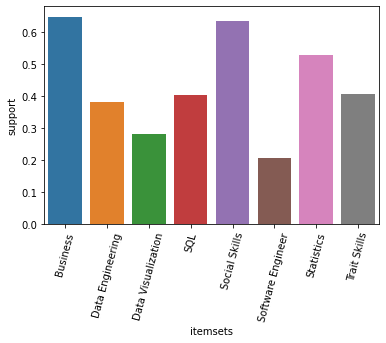

In [14]:
import seaborn as sns

_ = frequent_itemsets[frequent_itemsets['length'] == 1]
_['itemsets'] = _['itemsets'].astype("unicode").str.replace('[\(\)\'\{\}]|frozenset','', regex = True)
ax = sns.barplot(x="itemsets", y="support", data= _);
ax.set_xticklabels(ax.get_xticklabels(), rotation=75);


## Although this tells us a lot, let's break this down by job, and try again


In [15]:
temp = pd.DataFrame()

In [16]:
jobtypes = ['Data Analyst','Business Analyst','Data Scientist']

In [17]:
#If it contains Data and Analyst we will classify that as Data Analyst
data_analyst = jobs[(jobs['Job Title'].str.contains('[Aa]nalyst', flags=re.IGNORECASE)) & (jobs['Job Title'].str.contains('[dD]ata ', flags=re.IGNORECASE))]
data_analyst['jobtype'] = jobtypes[0]
temp = temp.append(data_analyst)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [18]:
business_analyst = jobs[(jobs['Job Title'].str.contains('[Aa]nalyst|[Ii]ntelligence|BI', regex = True, flags=re.IGNORECASE)) & (jobs['Job Title'].str.contains('Business |BI', flags=re.IGNORECASE))]
business_analyst['jobtype'] = jobtypes[1]
temp = temp.append(business_analyst)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [19]:
data_scientist = jobs[(jobs['Job Title'].str.contains('[Ss]cientist|Science', regex = True, flags=re.IGNORECASE)) & (jobs['Job Title'].str.contains('[dD]ata ', flags=re.IGNORECASE))]
data_scientist['jobtype'] = jobtypes[2]
temp = temp.append(data_scientist)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [20]:
jobs = temp

In [21]:
jobs.reset_index(inplace = True)
jobs.drop(['index'], axis =1, inplace = True)

## Re-run apriori and put up chart 2.0

In [22]:
# We want to retain the categories we just made, run apriori, and then recombine them
frequent_itemsets = pd.DataFrame()


for job in jobtypes:
    temp_frequent_itemsets = apriori_df(jobs.loc[jobs['jobtype'] == job,'refined skills'],.02)
    temp_frequent_itemsets['jobtype'] = job
    frequent_itemsets = frequent_itemsets.append(temp_frequent_itemsets)





In [23]:
frequent_itemsets

,support,itemsets,jobtype
0,0.789606,(Business),Data Analyst
1,0.462444,(Data Engineering),Data Analyst
2,0.401481,(Data Visualization),Data Analyst
3,0.050648,(Machine Learning),Data Analyst
4,0.600106,(SQL),Data Analyst
...,...,...,...
506,0.030172,"(SQL, Statistics, Software Engineer, Trait Ski...",Data Scientist
507,0.035920,"(SQL, Machine Learning, Statistics, Software E...",Data Scientist
508,0.020115,"(SQL, Machine Learning, Statistics, Software E...",Data Scientist
509,0.033046,"(SQL, Machine Learning, Statistics, Software E...",Data Scientist


In [24]:
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


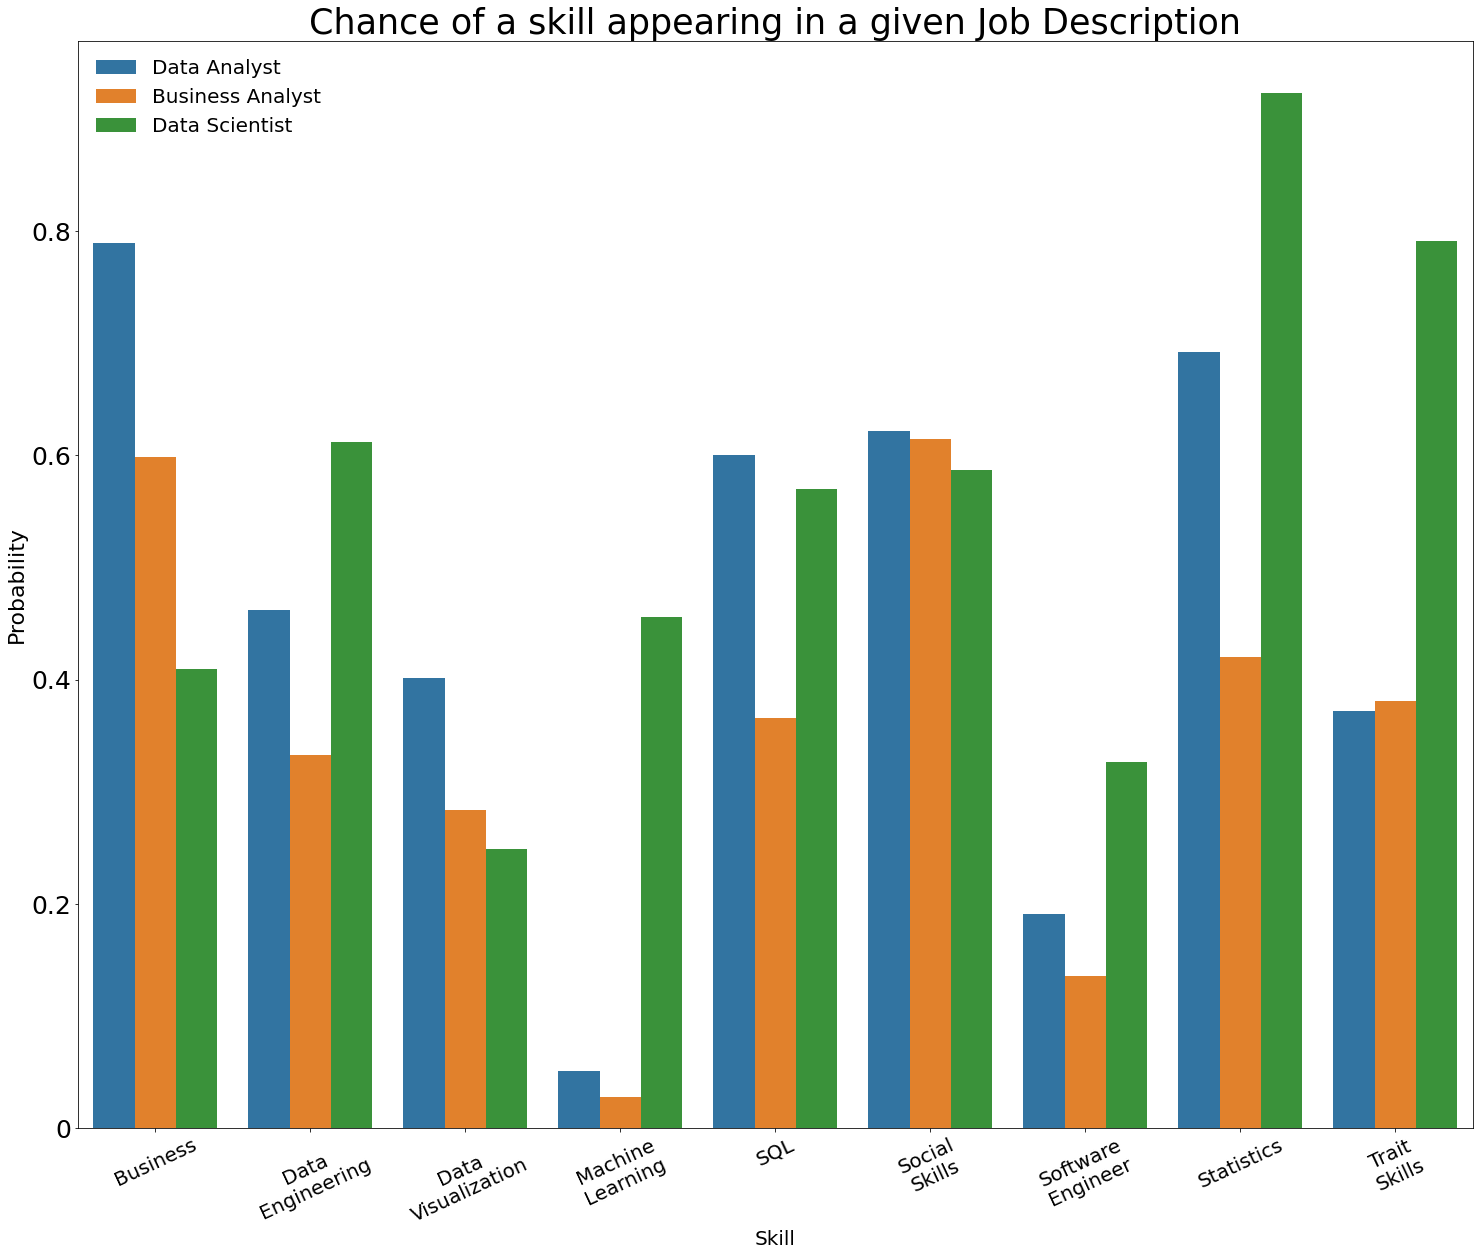

In [25]:
single_items = frequent_itemsets[frequent_itemsets['length'] == 1]
single_items['itemsets'] = single_items['itemsets'].astype("unicode").str.replace('[\(\)\'\{\}]|frozenset','', regex = True)
single_items['itemsets'] = single_items['itemsets'].str.replace(' ','\n', regex = True)
plt.figure(figsize =(25, 20)) 

plt.title('Chance of a skill appearing in a given Job Description', size = 35)
ax = sns.barplot(x="itemsets", y="support", hue = 'jobtype', data= single_items);
ax.set_xticklabels(ax.get_xticklabels(), rotation=25, size =20);
ax.set_yticklabels([0,0.2,0.4,0.6,0.8], size =25);
plt.xlabel('Skill', size = 20)
ax.legend(fontsize = 20, frameon= False)
plt.ylabel('Probability', size = 22)
plt.savefig('chart1.png', dpi = 500, format = 'png')

## Let's note a few things

*The support tells you the probability of that item (which actually represents a group of items, see above) is seen in a Job Description*


### **There are a lot of things we would expect**
* ML has a huge role in DS, but not in DA
* The primary skills for BA are Business and Social Skills
* The highest Data Visualization is seen in DA's
* The highest SWE is seen in DS

### **A few interesting things**
* The difference in Data Visualization across jobs is small compared to other itemsets across jobs
* Statistics knowledge is hugely correlated to job type 
* Trait Skills are much more important in DS jobs, where's social skills are slightly (slightly) less important
* DA's use business knowledge more than BA or DS

### Conclusions
That's up to you, although this chart clearly shows the difference between BA,DA,DS is not just semantic.  I'd rather work on getting more prescriptive advice. 


## Now I hear you saying, 'what a beautiful chart, it couldn't get any better', but there is one (or more) problems with the above chart:
Let's say you want to be a DA so you work on your Data Viz, and your SQL skills since they are some of the highest at 40% and 60% respectivly, but then you go to apply to jobs and 40% of the roles contain Data Viz, and 60% SQL, but there is no overlap between which jobs contain each!!  SQL and Data Viz are only listed separately, and therefore you're not qualified for any of the jobs.
We need a way to determine the strength of the connections between these items, and then also a  way to visualize that...


# Apriori Metrics: Conviction

I'm just going to get the metric, and visualize it first  

Let's start with our Goldilocks, the DA

In [26]:
import networkx as nx 

In [27]:
typ = 'Data Analyst'

In [28]:
rules = association_rules(apriori_df(jobs.loc[jobs['jobtype'] == typ,'refined skills'],.2), metric="conviction", min_threshold=1.4)

In [29]:
# 1 to 1 
rules['alength'] = rules['antecedents'].apply(lambda x: len(x))
rules['clength'] = rules['consequents'].apply(lambda x: len(x))
rules = rules[(rules['alength'] == 1) & (rules['clength'] == 1)]
rules['antecedents'] = rules['antecedents'].astype("unicode").str.replace('[\(\)\'\{\}]|frozenset','', regex = True)
rules['antecedents'] = rules['antecedents'].str.replace(' ','\n', regex = True)
rules['consequents'] = rules['consequents'].astype("unicode").str.replace('[\(\)\'\{\}]|frozenset','', regex = True)
rules['consequents'] = rules['consequents'].str.replace(' ','\n', regex = True)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,alength,clength
0,Data\nVisualization,Business,0.401481,0.789606,0.373578,0.930501,1.178437,0.056567,3.027282,1,1
1,Social\nSkills,Business,0.621396,0.789606,0.530019,0.852947,1.080219,0.039360,1.430741,1,1
2,Statistics,Business,0.692409,0.789606,0.588733,0.850267,1.076825,0.042003,1.405132,1,1
3,Data\nEngineering,SQL,0.462444,0.600106,0.346337,0.748928,1.247993,0.068822,1.592745,1,1
4,Data\nEngineering,Statistics,0.462444,0.692409,0.373182,0.806977,1.165463,0.052981,1.593547,1,1
5,Data\nVisualization,SQL,0.401481,0.600106,0.294102,0.732543,1.220689,0.053171,1.495171,1,1
6,Data\nVisualization,Statistics,0.401481,0.692409,0.333510,0.830698,1.199721,0.055520,1.816819,1,1
7,SQL,Statistics,0.600106,0.692409,0.476065,0.793301,1.145711,0.060546,1.488109,1,1
8,Trait\nSkills,Social\nSkills,0.371859,0.621396,0.278894,0.750000,1.206959,0.047822,1.514414,1,1


In [30]:
rules.sort_values(by = 'conviction')

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,alength,clength
2,Statistics,Business,0.692409,0.789606,0.588733,0.850267,1.076825,0.042003,1.405132,1,1
1,Social\nSkills,Business,0.621396,0.789606,0.530019,0.852947,1.080219,0.039360,1.430741,1,1
7,SQL,Statistics,0.600106,0.692409,0.476065,0.793301,1.145711,0.060546,1.488109,1,1
5,Data\nVisualization,SQL,0.401481,0.600106,0.294102,0.732543,1.220689,0.053171,1.495171,1,1
8,Trait\nSkills,Social\nSkills,0.371859,0.621396,0.278894,0.750000,1.206959,0.047822,1.514414,1,1
3,Data\nEngineering,SQL,0.462444,0.600106,0.346337,0.748928,1.247993,0.068822,1.592745,1,1
4,Data\nEngineering,Statistics,0.462444,0.692409,0.373182,0.806977,1.165463,0.052981,1.593547,1,1
6,Data\nVisualization,Statistics,0.401481,0.692409,0.333510,0.830698,1.199721,0.055520,1.816819,1,1
0,Data\nVisualization,Business,0.401481,0.789606,0.373578,0.930501,1.178437,0.056567,3.027282,1,1


In [31]:
#Make some edges, now that we've run apriori
weighted_edges = []

for x in range(len(rules)):
    weighted_edges.append((rules.iloc[x,0], rules.iloc[x,1], rules.iloc[x,8]))

In [32]:
G = nx.DiGraph() 
G.add_weighted_edges_from(weighted_edges)

In [33]:
#Change node size according to support
for i in list(G.nodes()): 
    G.nodes[i]['support'] = single_items.loc[(single_items['jobtype'] == typ) & (single_items['itemsets'] == i), 'support'].values


In [34]:
node_size = [50000*nx.get_node_attributes(G, 'support')[v] for v in G] 
edge_width = [(G[u][v]['weight']- 1)*12 if((G[u][v]['weight']- 1) > .4) else 0 for u, v in G.edges() ]


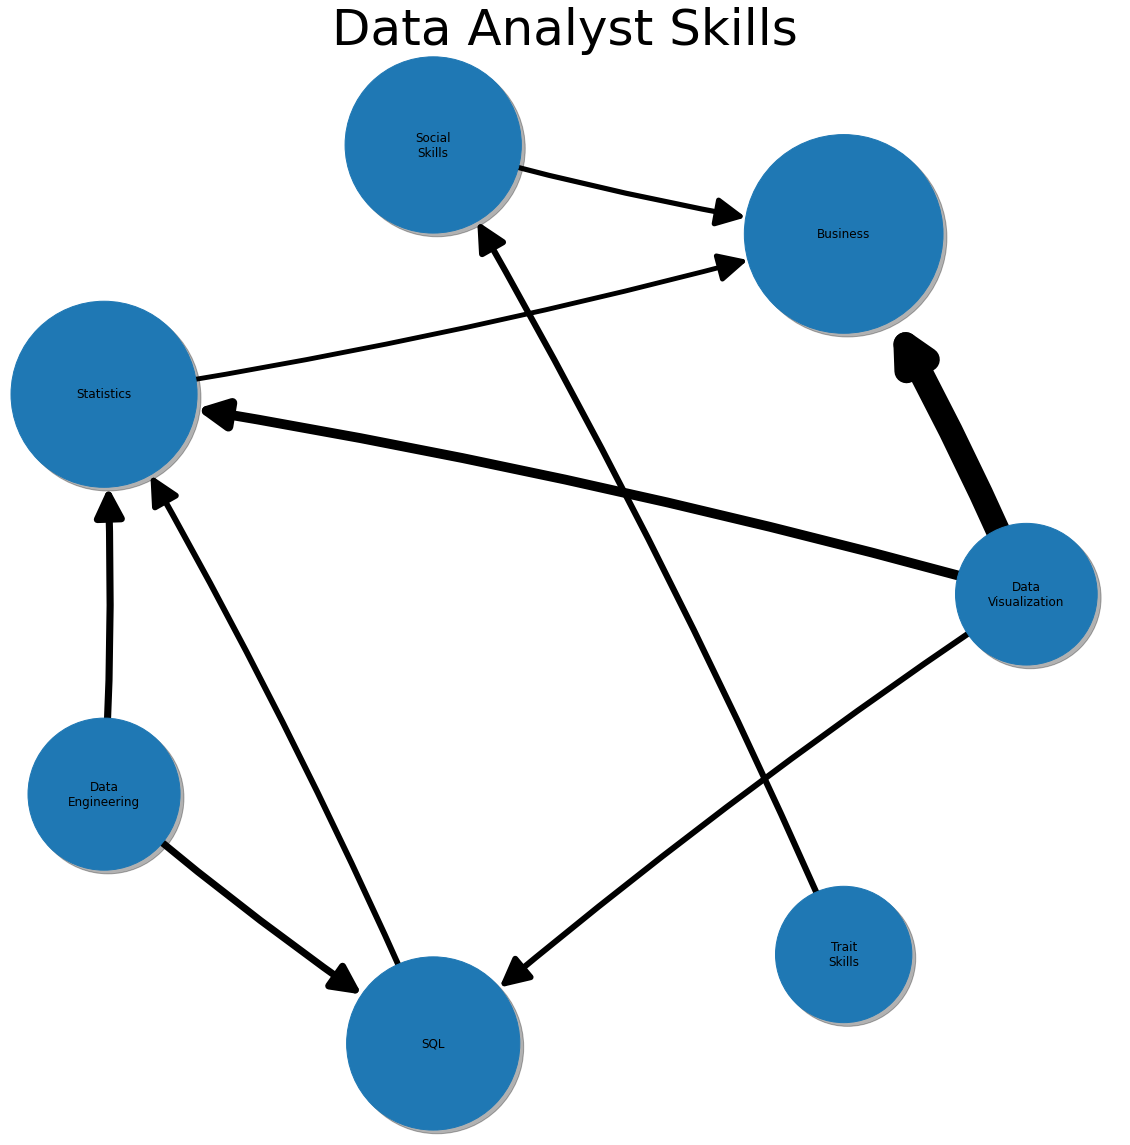

In [35]:
pos = nx.circular_layout(G)
plt.figure(figsize=(20,20))

pos_shadow = copy.deepcopy(pos)
shift_amount = 0.008
for idx in pos_shadow:
    pos_shadow[idx][0] += shift_amount
    pos_shadow[idx][1] -= shift_amount

nx.draw_networkx_nodes(G, pos_shadow, node_color='k', alpha=0.3,  node_size = node_size)    
    
nx.draw_networkx_nodes(G, pos, with_label = True, node_size = node_size,connectionstyle='arc3, rad = .03',arrowsize=60, width = edge_width)

nx.draw_networkx_labels(G, pos, with_label = True, node_size = node_size,connectionstyle='arc3, rad = .03',arrowsize=60, size = 25, width = edge_width)

nx.draw_networkx_edges(G, pos, with_label = True, node_size = node_size,connectionstyle='arc3, rad = .03',arrowsize=60, width = edge_width)
plt.title('Data Analyst Skills', size = 50)
plt.axis('off')
plt.plot();

In [36]:
def make_network_graph(jobtype, min_conviction):
    rules = association_rules(apriori_df(jobs.loc[jobs['jobtype'] == jobtype,'refined skills'],.15), metric="conviction", min_threshold=.5)
    # 1 to 1 
    rules['alength'] = rules['antecedents'].apply(lambda x: len(x))
    rules['clength'] = rules['consequents'].apply(lambda x: len(x))
    rules = rules[(rules['alength'] == 1) & (rules['clength'] == 1)]
    rules['antecedents'] = rules['antecedents'].astype("unicode").str.replace('[\(\)\'\{\}]|frozenset','', regex = True)
    rules['antecedents'] = rules['antecedents'].str.replace(' ','\n', regex = True)
    rules['consequents'] = rules['consequents'].astype("unicode").str.replace('[\(\)\'\{\}]|frozenset','', regex = True)
    rules['consequents'] = rules['consequents'].str.replace(' ','\n', regex = True)


    #Make some edges, now that we've run apriori
    weighted_edges = []

    G = nx.DiGraph()
    
    for x in range(len(rules)):
        if(rules.iloc[x,8] > min_conviction):
            weighted_edges.append((rules.iloc[x,0], rules.iloc[x,1], rules.iloc[x,8]))
        
        else:
            G.add_node(rules.iloc[x,1])
            G.add_node(rules.iloc[x,0])
        
        
     
    G.add_weighted_edges_from(weighted_edges)
    
    #Change node size according to support
    for i in list(G.nodes()): 
        G.nodes[i]['support'] = single_items.loc[(single_items['jobtype'] == jobtype) & (single_items['itemsets'] == i), 'support'].values
        
    node_size = [60000*nx.get_node_attributes(G, 'support')[v] for v in G] 
    edge_width = [(G[u][v]['weight']- 1)*10.5 if((G[u][v]['weight']- 1) > .1) else 0 for u, v in G.edges() ]

    pos = nx.circular_layout(G)
    plt.figure(figsize=(27,22))


    pos_shadow = copy.deepcopy(pos)
    shift_amount = 0.008
    for idx in pos_shadow:
        pos_shadow[idx][0] += shift_amount
        pos_shadow[idx][1] -= shift_amount

    nx.draw_networkx_nodes(G, pos_shadow, node_color='k', alpha=0.3,  node_size = node_size)   

    nx.draw_networkx_nodes(G, pos, with_label = True, node_size = node_size,connectionstyle='arc3, rad = .03',arrowsize=60, width = edge_width)

    nx.draw_networkx_labels(G, pos, with_label = True, node_size = node_size,connectionstyle='arc3, rad = .03',arrowsize=60, size = 20, font_size = 28, width = edge_width, font_weight = 'bold', font_color = 'darkorange')

    nx.draw_networkx_edges(G, pos, with_label = True, node_size = node_size,connectionstyle='arc3, rad = .03',arrowsize=60, width = edge_width)
    plt.title(jobtype + ' Skills', size = 50)
    plt.axis('off')
    plt.plot();

# Results

## How do I read these

### **Intuitively**
The size of the node tells you the probability of that word appearing in a Job Description.

The width of an arrow tells you the probability that if that word appears in a Job Description, the node it's pointing to will appear as well.

The arrows tell you what skill implies another, so if a node has many arrows pointing to it, then it is useful in all subtypes of that job.  

If you have a skill, use the arrows to see what other skills you should learn. If you get to a dead end node, then you can start looking at the arrows that point to it as new skills to branch out to.

I want to note here, if you're familiar with apriori you will see that I haven't included any multi-item sets.  This makes it dangerous to go from one arrow to the next to the next, so be careful thinking about large chanins.  Because we can run into the same problem I talked about above.

### **Mathematically**

First let's look at two other measures

Confidence:

### $\text{confidence}(A\rightarrow B) = \frac{P(A \cap B)}{P(A)}, \;\;\; \text{range: } [0, 1]$

This tells us how often A and B occur over how often A occurs.  Note it doesn't take into account P(B), for this we use lift

### $\text{lift}(A\rightarrow B) = \frac{P(A \cap B)}{P(A)P(B)}, \;\;\; \text{range: } [0, \infty]$

This tells us how often A and  B occur together over how often we would expect them to occur together.  However, if P(A) is small and P(B) big, it may be that most A's include B, but because B is so large the lift is low.  Look for example at Data Visualization and Business in the BA chart below.  
We want something that combines confidence and lift, this is conviction.

Conviction is defined as: 
### $\text{conviction}(A\rightarrow B) = \frac{P(A) P(-B)}{P(A \cap -B)}, \;\;\; \text{range: } [0, \infty]$

This solves the problem of the last example, because if most A's include B the conviction will capture this measure.  Consult [here]( https://michael.hahsler.net/research/association_rules/measures.html#conviction) for a better explanation. 



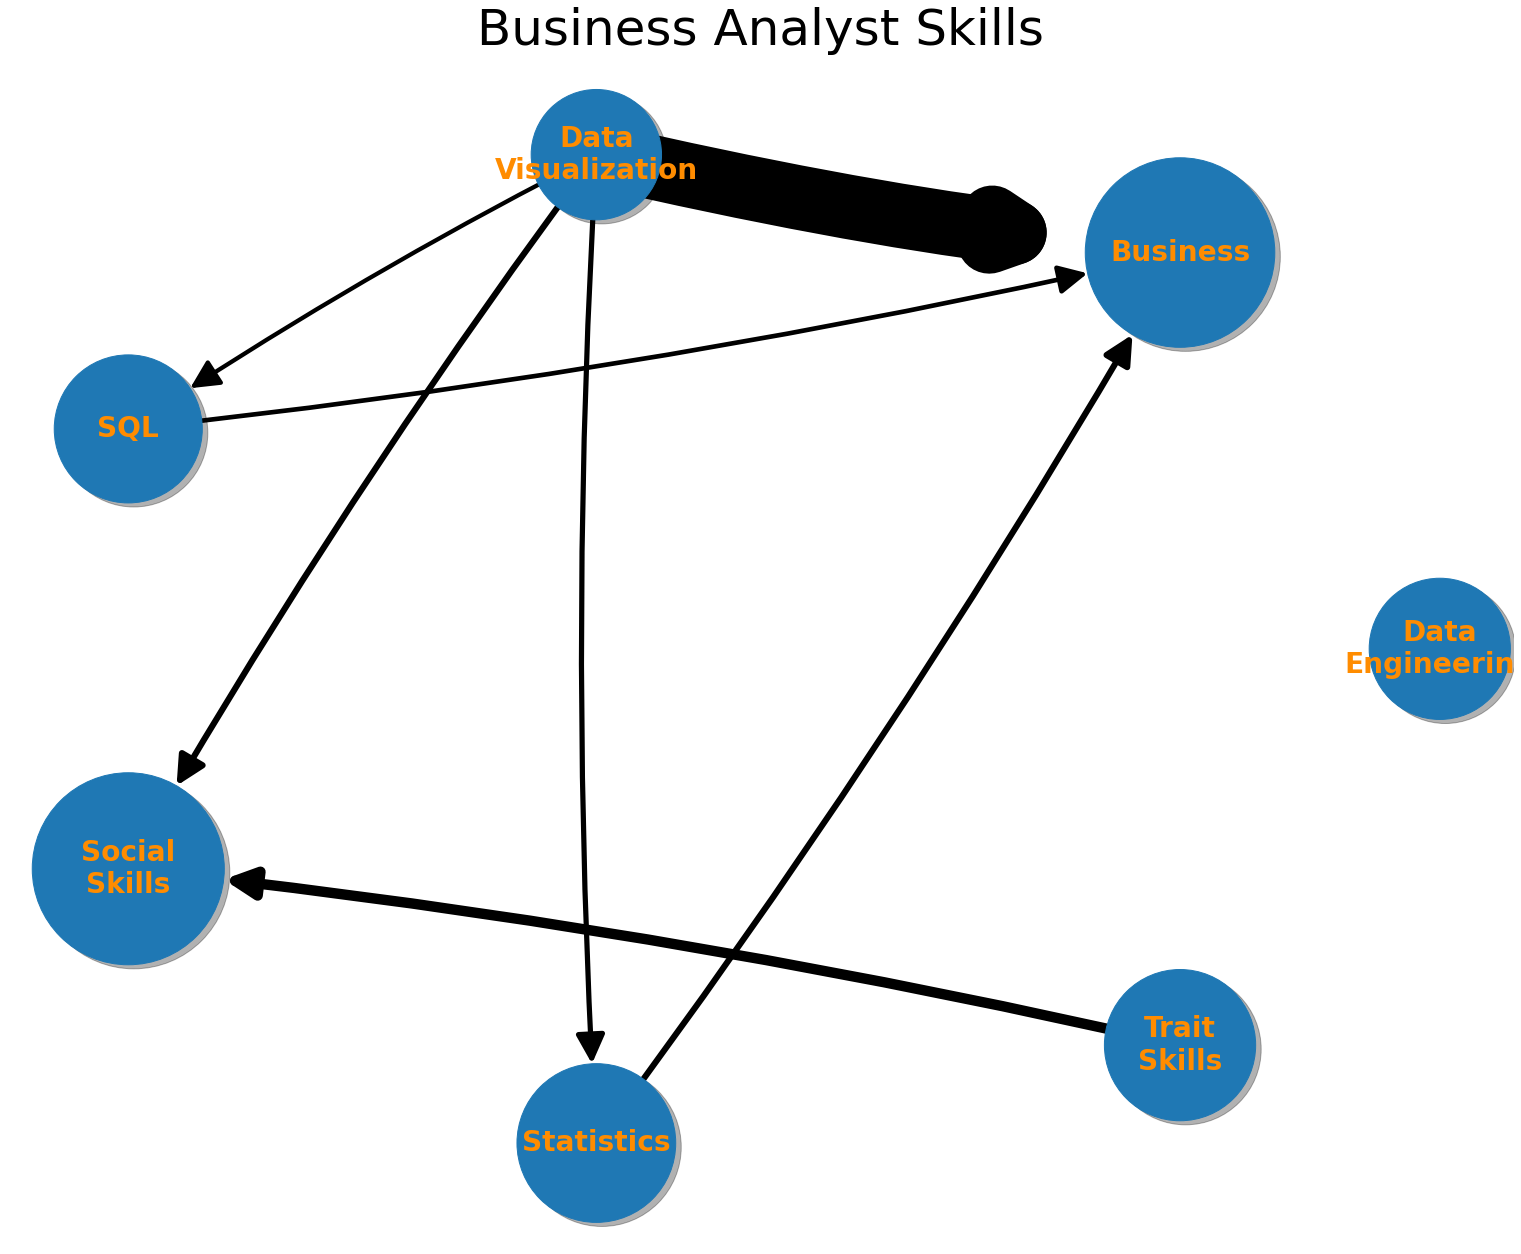

In [37]:
make_network_graph(jobtypes[1],1.4)

Hopefully this speaks for itself.  

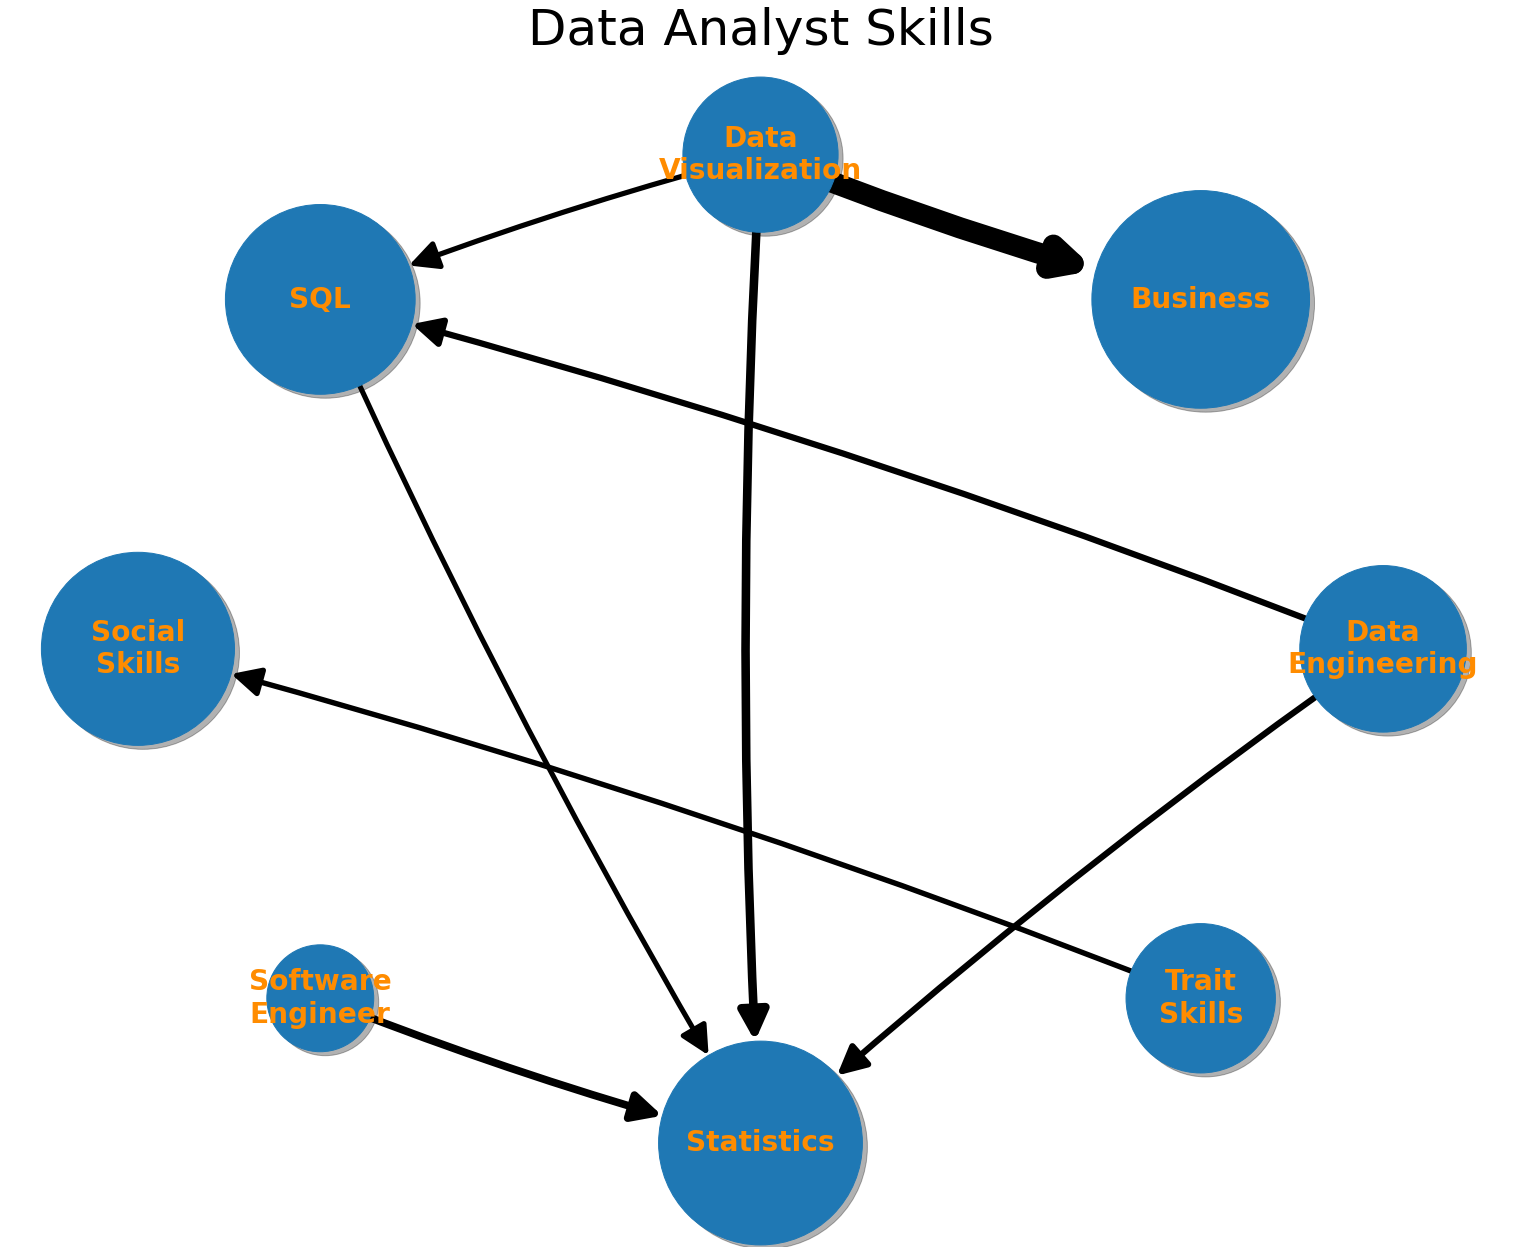

In [38]:
make_network_graph(jobtypes[0],1.45)
plt.savefig('DAgraph.svg', format='svg', dpi=1200)

Note things that only have outward arrows, this means it cannot be used on its own  

Also, note the change in relative size of the statistics and business nodes

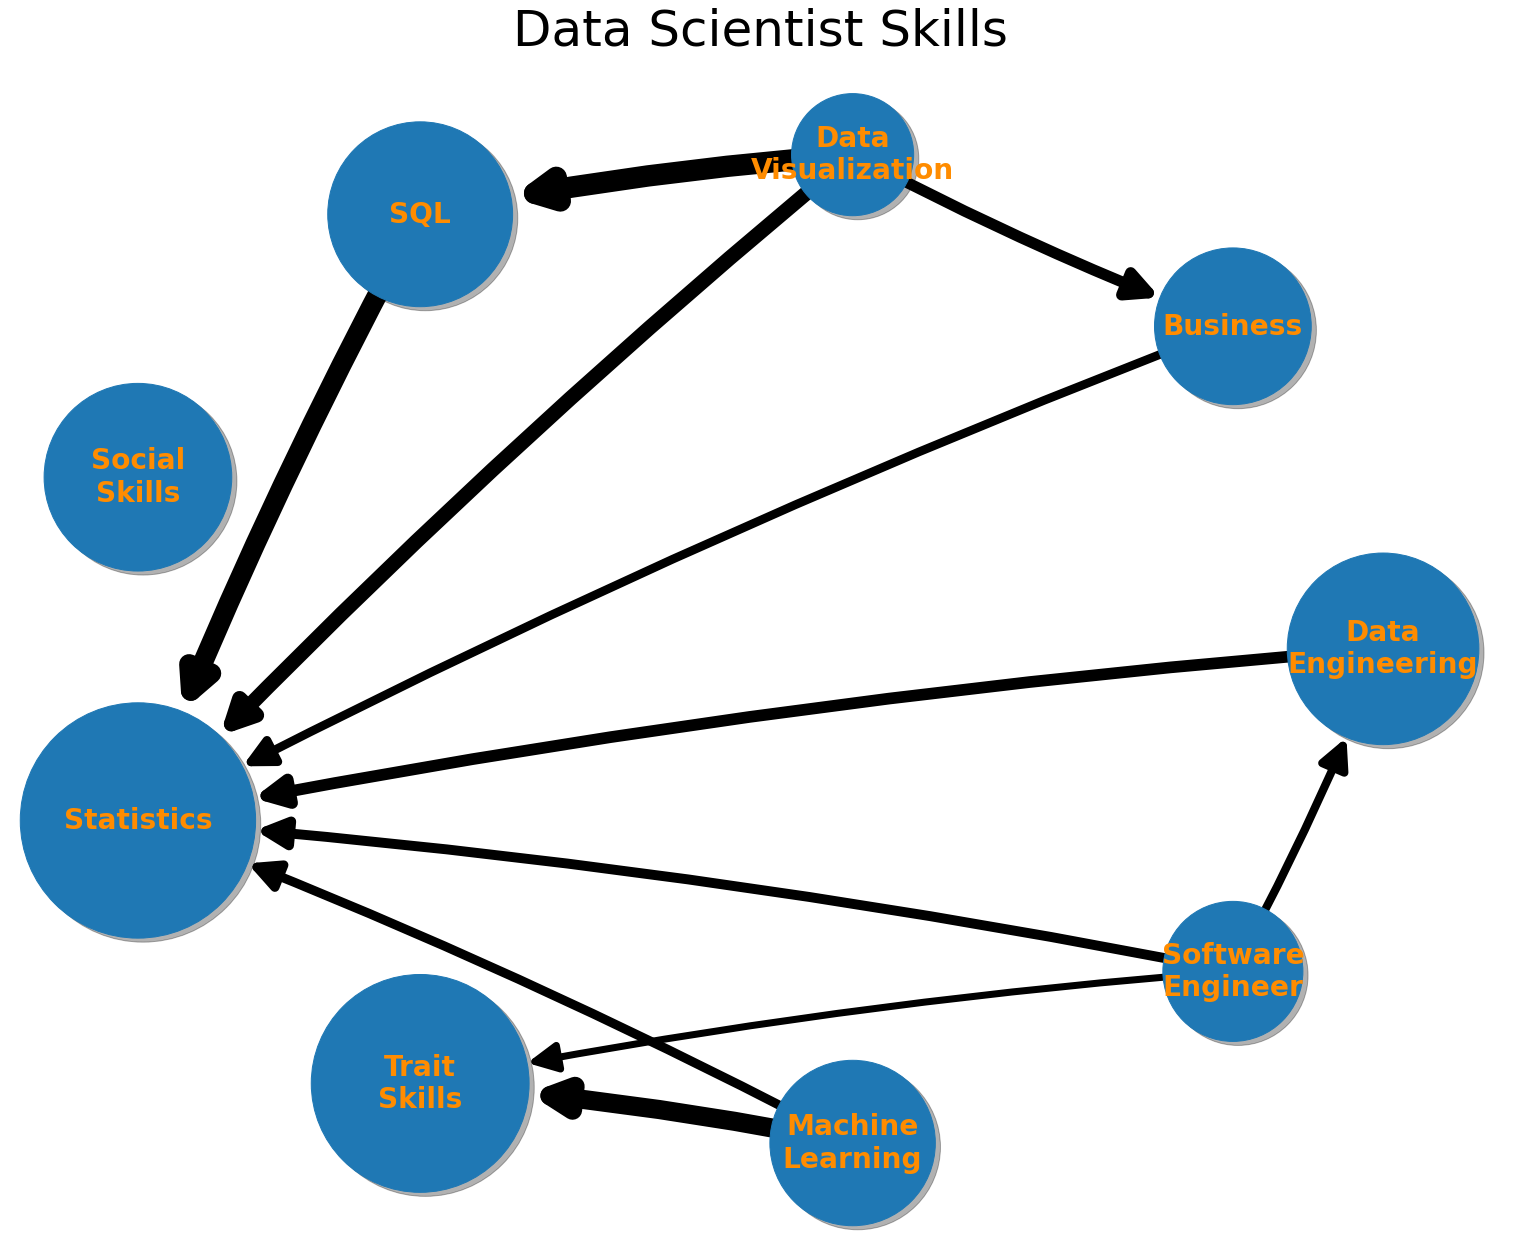

In [39]:
make_network_graph(jobtypes[2],1.6)
plt.savefig('DSgraph.svg', format='svg', dpi=1200)

## Thank you for reading, I hope this was helpful.  
